In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data.dataset import Dataset, Subset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import cv2
import copy


from torch._utils import _accumulate

In [36]:
class ObjectsDataset(Dataset):
  
  def __init__(self, dataset_dir, frames, labels_index, image_type):
    # image_type can be original, gray image or color-opponency. It is expected 
    # that images with these types are already available - gotten through preprocessing offline. 
    
    self.labels = labels_index
    self.dataset_dir = dataset_dir
    self.transforms = transforms
    self.image_type = image_type
    self.frames = frames
    #self.labels_names = labels_names
    self.dataset_dir = dataset_dir
    
    
  def __len__(self):
    return len(self.frames)
    
  def __getitem__(self, index):
    frame_path = self.frames[index]
    label_index = self.labels[index]
    #plant_name = self.labels_names[label_index]
    
    image = cv2.imread(frame_path)
    #image = cv2.resize(image, (1080, 720))  
    
    image = image/ 255.0
    image=torch.from_numpy(image.astype('float32')).permute(2, 0, 1)
    
    label=torch.from_numpy(np.asarray(label_index).astype('long'))
        
    return (image, label) 

In [37]:
import os
import re

def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

def get_dataloader(image_type='original', skip=6, batch_size=64, shuffle=True):
    classes = ['bag','beer','book','case','coffee','cup','deodorant','eraser',
               'hole','mouse','mug','sleep','speaker','spray','stapler','tape',
               'tea','tissues','umbrella','watch']
    
    root_path = '/content/drive/My Drive/RODframes2/RODframes/'
    model_path = '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/models/'

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    #image_path = os.path.join(root_path)
    train_path = os.path.join(root_path, 'train/')
    test_path = os.path.join(root_path, 'test/')
    
    master_frames = []
    master_labels = []
    
    frames = []
    labels = []

    errors = []
    min_count = 7200
    for index, obj in enumerate(classes):
        print('Iterating over {}'.format(obj))
        try:
            object_frames = []
            labels_index = []

            object_path = os.path.join(train_path, obj+'/light/original/')
            count_index = 0

            for frame_index, frame in enumerate(os.listdir(object_path)):
                if count_index%skip == 0:
                    frame_path = os.path.join(object_path, frame)
                    object_frames.append(frame_path)
                    labels_index.append(frame_index)
                count_index += 1
            
            if len(object_frames) < min_count:
                min_count = len(object_frames)
            sorted_object_frames = sorted(object_frames, key=natural_key)
            master_frames.append(sorted_object_frames)
            master_labels.append(labels_index)
            print('Number of images for class ',obj, ': ', len(sorted_object_frames))
        
        except OSError as err:
            print("OS error for object {}: {}".format(obj, err))
            errors.append((index, obj))
            continue
    
    #for ind, obj in errors:
        #classes.remove(obj)
        #del master_frames[ind]
        #del master_labels[ind]
        
    print(errors)
    print(classes)
    
    for i in range(0, min_count):
        for object_index in range(len(classes)-1):
            frames.append(master_frames[object_index][i])
            labels.append(master_labels[object_index][i])

    dataset = ObjectsDataset(root_path, frames, labels, image_type)

    train_size = int (0.8 * len(dataset))
    validation_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - validation_size
    train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size, test_size])

    dataset_dict = {'train' : train_dataset, 'validation' : validation_dataset, 'test' : test_dataset}

    dataloader = {x : torch.utils.data.DataLoader(dataset_dict[x], batch_size = batch_size, shuffle = shuffle, 
                                                  num_workers = 0, drop_last=True) for x in ['train', 'test', 'validation']}
    
    dataset_sizes = {x: len(dataset_dict[x]) for x in ['train', 'test', 'validation']}
    print('Dataset size is ', dataset_sizes)

    return dataloader
    

In [31]:
dataset = get_dataloader(image_type = '', skip = 10, batch_size=8)

cuda:0
Iterating over bag
Number of images for class  bag :  210
Iterating over beer
Number of images for class  beer :  217
Iterating over book
Number of images for class  book :  212
Iterating over case
Number of images for class  case :  197
Iterating over coffee
Number of images for class  coffee :  209
Iterating over cup
Number of images for class  cup :  224
Iterating over deodorant
Number of images for class  deodorant :  194
Iterating over eraser
Number of images for class  eraser :  212
Iterating over hole
Number of images for class  hole :  212
Iterating over mouse
Number of images for class  mouse :  201
Iterating over mug
Number of images for class  mug :  210
Iterating over sleep
Number of images for class  sleep :  209
Iterating over speaker
Number of images for class  speaker :  205
Iterating over spray
Number of images for class  spray :  204
Iterating over stapler
Number of images for class  stapler :  208
Iterating over tape
Number of images for class  tape :  200
Ite

In [57]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = self.t_conv2(x)
        x = F.sigmoid(x)
                
        return x
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)
        self.unconv1 = nn.ConvTranspose2d(6,3,kernel_size=(5,5))
        self.maxunpool1 = nn.MaxUnpool2d(kernel_size=(2,2))
        self.unmaxunpool2 = nn.MaxUnpool2d(kernel_size=(2,2))
        
        self.encoder1 = nn.Sequential(
            nn.Tanh(),
            nn.Conv2d(6, 12,kernel_size=(5,5)),
        )
        
        self.encoder2 = nn.Sequential(
            nn.Tanh(),
            nn.Conv2d(12, 16, kernel_size=(5,5)),
            nn.Tanh()
        )
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(16, 12, kernel_size=(5,5)),
            nn.Tanh()
        )
        
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(12,6,kernel_size=(5,5)),
            nn.Tanh(),
        )
        

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x,indices1 = self.maxpool1(x)
        x = self.encoder1(x)
        x,indices2 = self.maxpool2(x)
        x = self.encoder2(x)
        
        # Decoder
        x = self.decoder2(x)
        x = self.unmaxunpool2(x, indices2)
        x = self.decoder1(x)
        x = self.maxunpool1(x,indices1)
        x = self.unconv1(x)
        x = nn.Tanh()(x)
        return x


In [38]:
model = ConvAutoencoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#model = Autoencoder()

criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
model.to(device)
n_epochs = 5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in dataset['train']:
       
        # _ stands in for labels, here
        # no need to flatten images
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        #print(images.shape)
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(dataset['train'])
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.148114
Epoch: 2 	Training Loss: 0.018903
Epoch: 3 	Training Loss: 0.017968
Epoch: 4 	Training Loss: 0.016961
Epoch: 5 	Training Loss: 0.010251


In [61]:
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


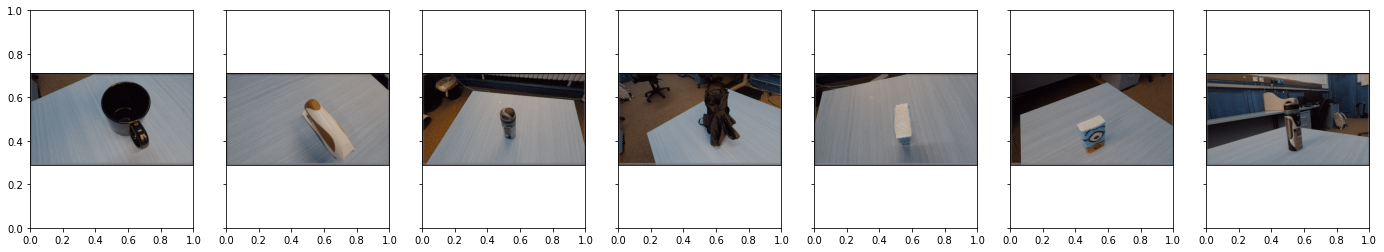

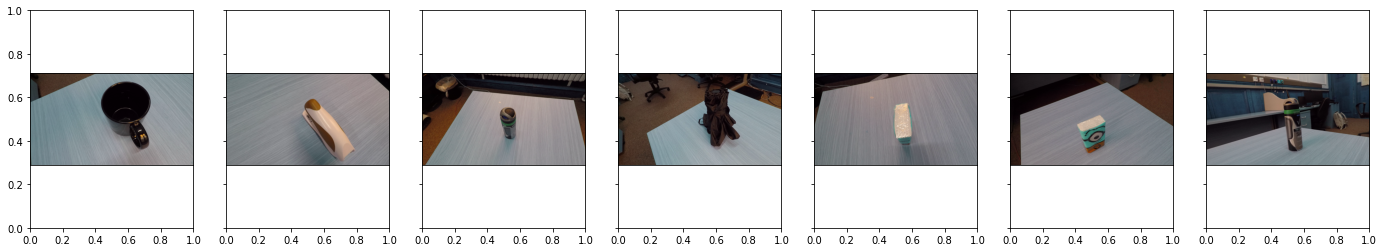

In [62]:
dataiter = iter(dataset['test'])
images, labels = dataiter.next()

images, labels = images.to(device), labels.to(device)
# get sample outputs
output = model(images)
# prep images for display
images = images.cpu().numpy()

# output is resized into a batch of images
output = output.view(8, 3, 1080, 1920)

output = output.cpu().detach().numpy()

fig, axes = plt.subplots(nrows=1, ncols=7, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(len(output)-1):
    ax = fig.add_subplot(1, 7, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    #ax.set_title(classes[labels[idx]])
    
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=1, ncols=7, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(len(output)-1):
    ax = fig.add_subplot(1, 7, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(classes[labels[idx]])

In [58]:
model = Autoencoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#model = Autoencoder()

criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
model.to(device)
n_epochs = 3

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in dataset['train']:
       
        # _ stands in for labels, here
        # no need to flatten images
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        #print(images.shape)
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(dataset['train'])
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.111426
Epoch: 2 	Training Loss: 0.033605
Epoch: 3 	Training Loss: 0.023935


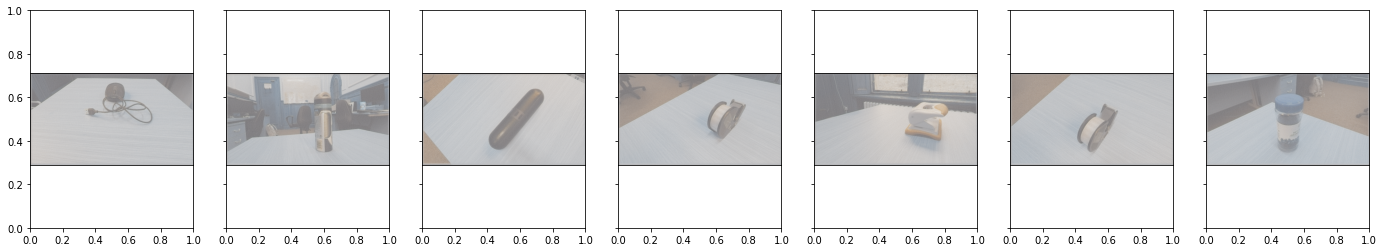

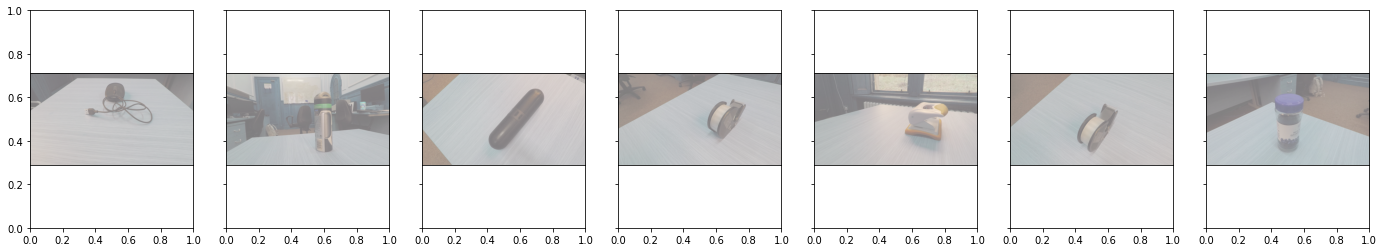

In [60]:
dataiter = iter(dataset['test'])
images, labels = dataiter.next()

images, labels = images.to(device), labels.to(device)
# get sample outputs
output = model(images)
# prep images for display
images = images.cpu().numpy()

# output is resized into a batch of images
output = output.view(8, 3, 1080, 1920)

output = output.cpu().detach().numpy()

fig, axes = plt.subplots(nrows=1, ncols=7, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(len(output)-1):
    ax = fig.add_subplot(1, 7, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    #ax.set_title(classes[labels[idx]])
    
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=1, ncols=7, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(len(output)-1):
    ax = fig.add_subplot(1, 7, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(classes[labels[idx]])

In [64]:
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/models/conv_model')